In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from xgboost import XGBRFRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_squared_log_error
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import seaborn as sns


In [25]:
# Load the data
df = pd.read_csv("train.csv")
df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
0,748,2.75,1,75.00,24,6.300,0
1,1187,3.43,1,105.00,24,13.200,0
2,730,3.12,1,71.25,0,26.625,1
3,671,5.63,3,90.00,0,9.750,0
4,329,2.09,1,45.00,12,13.200,0


- 'trip_duration': How long did the journey last?[in Seconds]

- 'distance_traveled': How far did the taxi travel?[in Km]

- 'num_of_passengers': How many passengers were in the taxi?

- 'fare': What's the base fare for the journey?[In INR]

- 'tip': How much did the driver receive in tips?[In INR]

- 'miscellaneous_fees': Were there any additional charges during the trip?e.g. tolls, convenience fees, GST etc.[In INR]

- 'total_fare': The grand total for the ride (this is your prediction target!).[In INR]

- 'surge_applied': Was there a surge pricing applied? Yes or no?

In [26]:
df.shape

(209673, 7)

In [27]:
# This code checks the type of the train variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  int64  
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  int64  
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   surge_applied       209673 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 11.2 MB


In [28]:
# This code describes the training data
df.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
count,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000
mean,1173.181478,5.054431,1.292808,99.623431,13.030824,15.136829,0.280523
std,4775.653621,125.217419,0.930754,85.602702,20.367764,12.553436,0.449256
min,0.000000,0.020000,0.000000,0.000000,0.000000,-0.500000,0.000000
25%,446.000000,1.950000,1.000000,52.500000,0.000000,6.000000,0.000000
50%,707.000000,3.200000,1.000000,75.000000,9.000000,9.750000,0.000000
75%,1098.000000,5.730000,1.000000,116.250000,20.000000,26.450000,1.000000
max,86387.000000,57283.910000,9.000000,4466.250000,2500.000000,435.000000,1.000000


In [29]:
df.corr()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
trip_duration,1.000000,0.005774,-0.001477,0.150331,0.029132,0.046432,0.029961
distance_traveled,0.005774,1.000000,-0.000299,0.035934,0.013487,0.021734,0.005567
num_of_passengers,-0.001477,-0.000299,1.000000,0.013224,0.007277,0.010044,0.006360
fare,0.150331,0.035934,0.013224,1.000000,0.302044,0.299321,0.146687
tip,0.029132,0.013487,0.007277,0.302044,1.000000,0.320919,0.239334
miscellaneous_fees,0.046432,0.021734,0.010044,0.299321,0.320919,1.000000,0.715497
surge_applied,0.029961,0.005567,0.006360,0.146687,0.239334,0.715497,1.000000


In [30]:
df.shape

(209673, 7)

### Checked Assumptions of Linear Regression

### 1) Checked Multicolinearity

In [31]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select all columns for VIF calculation
columns_for_vif = df.columns

# Create a DataFrame to store the VIF results
vif_data = pd.DataFrame()
vif_data['Feature'] = columns_for_vif
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(columns_for_vif))]

# Print the VIF results
print(vif_data)

              Feature       VIF
0       trip_duration  1.084038
1   distance_traveled  1.003149
2   num_of_passengers  1.857478
3                fare  2.521444
4                 tip  1.657926
5  miscellaneous_fees  4.919332
6       surge_applied  2.843864


In [32]:
df

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
0,748,2.75,1,75.00,24,6.300,0
1,1187,3.43,1,105.00,24,13.200,0
2,730,3.12,1,71.25,0,26.625,1
3,671,5.63,3,90.00,0,9.750,0
4,329,2.09,1,45.00,12,13.200,0
...,...,...,...,...,...,...,...
209668,1617,8.42,1,150.00,47,5.800,0
209669,438,1.29,1,48.75,12,34.575,1
209670,571,2.82,1,63.75,0,6.000,0
209671,491,2.16,1,56.25,0,13.500,0


In [33]:
df = df[df['fare'] <= 250]

In [34]:
df = df[df['distance_traveled'] <= 150]

In [35]:
df = df[df['miscellaneous_fees'] <= 300]

In [36]:
df = df[df['tip'] <= 1000]

Removed 10 raws which has extreme values 

In [37]:
df.shape

(200764, 7)

## 2) Checked Linearity between independent var. and dependent var.

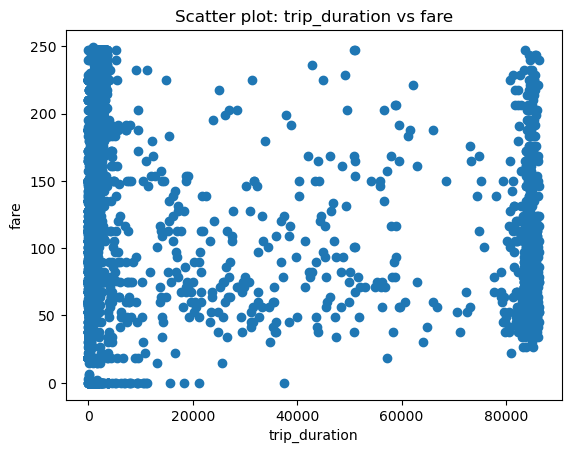

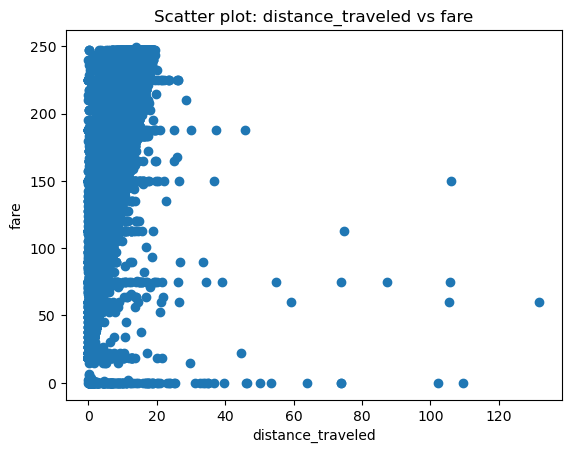

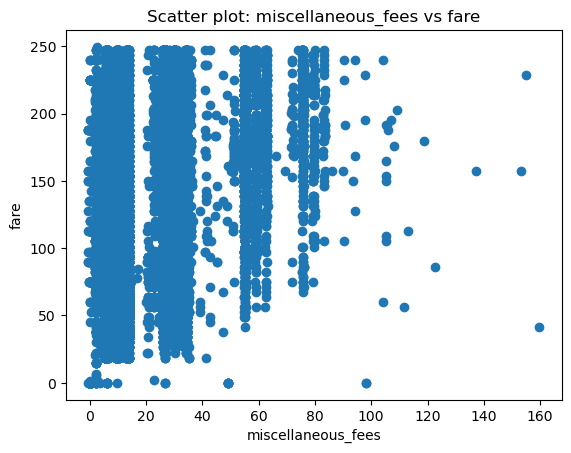

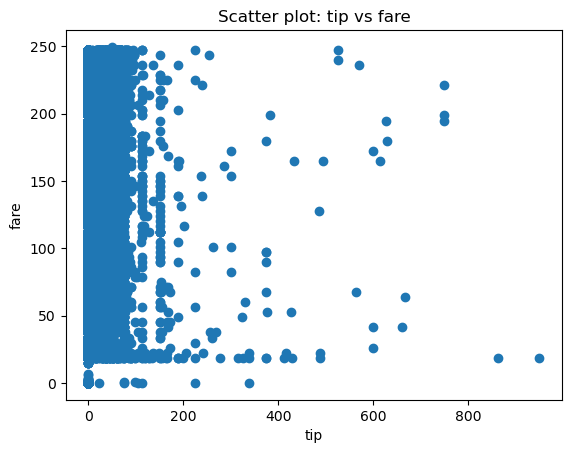

In [38]:
import matplotlib.pyplot as plt

# Select the features for scatter plots
features = ['trip_duration', 'distance_traveled','miscellaneous_fees','tip']

# Generate scatter plots
for feature in features:
    plt.scatter(df[feature], df['fare'])
    plt.xlabel(feature)
    plt.ylabel('fare')
    plt.title(f'Scatter plot: {feature} vs fare')
    plt.show()


In [39]:
X=df.drop('fare',axis=1)
y=df.fare

In [40]:
X

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
0,748,2.75,1,24,6.300,0
1,1187,3.43,1,24,13.200,0
2,730,3.12,1,0,26.625,1
3,671,5.63,3,0,9.750,0
4,329,2.09,1,12,13.200,0
...,...,...,...,...,...,...
209667,354,1.24,1,0,6.000,0
209668,1617,8.42,1,47,5.800,0
209669,438,1.29,1,12,34.575,1
209670,571,2.82,1,0,6.000,0


### Fitted Linear Model

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)
coefficients = model.coef_
# Print the coefficients
for i, feature_name in enumerate(X.columns):
    print(f"Coefficient for {feature_name}: {coefficients[i]}")

Mean Squared Error: 473.9862800631787
R-squared: 0.788189612235179
Coefficient for trip_duration: 0.000263147150184384
Coefficient for distance_traveled: 12.314141055417023
Coefficient for num_of_passengers: 0.06121864994252361
Coefficient for tip: 0.13804069228556934
Coefficient for miscellaneous_fees: -0.22298808542042425
Coefficient for surge_applied: 9.05365046343111


### 3) Checked homoscedasticity

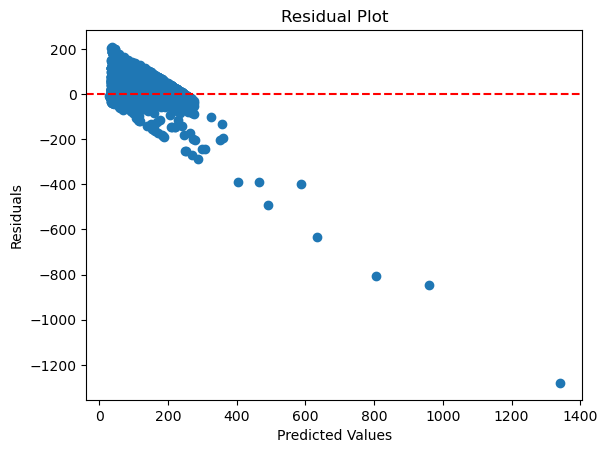

In [42]:
residuals = y_test - y_pred

# Generate the residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### 4) Checked Normality

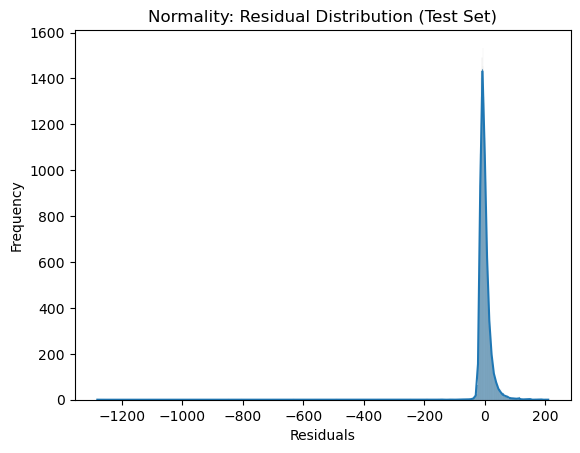

In [43]:
# Plotting normality: Histogram of residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Normality: Residual Distribution (Test Set)')
plt.show()


In [53]:
model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative mean squared errors to positive
mse_scores = -cv_scores

# Calculate the average mean squared error across folds
avg_mse = mse_scores.mean()

# Print the average mean squared error
print("Average Mean Squared Error:", avg_mse)

Average Mean Squared Error: 482.82263130166746


### Used RFE and SFS for select best features

In [45]:
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LinearRegression

# Sequential Feature Selection (SFS)
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)
X_sfs = sfs.fit_transform(X, y)
selected_features_sfs = X.columns[sfs.get_support(indices=True)].tolist()
print("Selected Features (SFS):", selected_features_sfs)

# Recursive Feature Elimination (RFE)
rfe = RFE(LinearRegression(), n_features_to_select=3)
X_rfe = rfe.fit_transform(X, y)
selected_features_rfe = X.columns[rfe.get_support(indices=True)].tolist()
print("Selected Features (RFE):", selected_features_rfe)


Selected Features (SFS): ['distance_traveled', 'tip', 'surge_applied']
Selected Features (RFE): ['distance_traveled', 'miscellaneous_fees', 'surge_applied']


In [46]:
X = df[['trip_duration', 'distance_traveled', 'tip']]
y = df['fare']

model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative mean squared errors to positive
mse_scores = -cv_scores

# Calculate the average mean squared error across folds
avg_mse = mse_scores.mean()

# Print the average mean squared error
print("Average Mean Squared Error:", avg_mse)

Average Mean Squared Error: 476.5296807431325


In [47]:
X = df[['distance_traveled', 'num_of_passengers', 'miscellaneous_fees']]
y = df['fare']

model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative mean squared errors to positive
mse_scores = -cv_scores

# Calculate the average mean squared error across folds
avg_mse = mse_scores.mean()

# Print the average mean squared error
print("Average Mean Squared Error:", avg_mse)

Average Mean Squared Error: 482.82263130166746


### Error Curve for find best K in KNN

In [ ]:
# Define a range of K values to evaluate
k_values = range(1, 30)

# Initialize empty lists to store the error values
mse_values = []

# Iterate over each K value
for k in k_values:
    # Create the KNN regressor
    regressor = KNeighborsRegressor(n_neighbors=k)
    
    # Train the model
    regressor.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = regressor.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)


# Plot the error curve
plt.plot(k_values, mse_values, label='Mean Squared Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Error Curve for KNN Regression')
plt.legend()
plt.show()

# Find the best K value with the lowest error
best_k = k_values[np.argmin(mse_values)]
print('Best K:', best_k)


In [65]:
from sklearn.neighbors import KNeighborsRegressor

# Create the KNN regressor
regressor = KNeighborsRegressor(n_neighbors=26)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)


Mean Squared Error: 269.74154250036145
R-squared: 0.8794605179169596


## DecisionTree Regressor

In [50]:
regressor = DecisionTreeRegressor()

# Train the model
regressor.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2) 

Mean Squared Error: 367.83341551474626
R-squared: 0.8356261738996917


<!-- ## RandomForest Regressor -->

In [51]:
importance = regressor.feature_importances_

# Print the feature importance scores
for feature, score in zip(X_train.columns, importance):
    print(f"{feature}: {score}")

const: 0.0
distance_traveled: 0.9447524120242563
num_of_passengers: 0.007088846642569564
miscellaneous_fees: 0.048158741333174195


## Conclusion:

#### Without removing outlier Linear model gave low R2 but decision tree gives good R2 


#### Linear regression is sensitive to outlier but decision tree is not sensitive .